#  Выпускной проект: Телеком.

# Описание проекта
Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. 

**Задача проекта** — обучить модель для прогноза оттока клиентов.
    
Описание услуг оператора связи «ТелеДом»:

**Основные услуги**
- `Стационарную телефонную связь.` Телефон можно подключить к нескольким линиям одновременно.

- `Интернет.` Подключение может быть двух типов: через телефонную линию DSL или оптоволоконный кабель.

**Дополнительные услуги**

- `Интернет-безопасность:` антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- `Выделенная линия технической поддержки` (TechSupport);
- `Облачное хранилище файлов` для резервного копирования данных (OnlineBackup);
- `Стриминговое телевидение` (StreamingTV)
- `каталог фильмов` (StreamingMovies).

# Описание данных
Данные состоят из нескольких файлов, полученных из разных источников:
- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.



**contract_new.csv**

- `customerID` — идентификатор абонента;
- `BeginDate` — дата начала действия договора;
- `EndDate` — дата окончания действия договора;
- `Type` — тип оплаты: раз в год-два или ежемесячно;
- `PaperlessBilling` — электронный расчётный лист;
- `PaymentMethod` — тип платежа;
- `MonthlyCharges` — расходы за месяц;
- `TotalCharges` — общие расходы абонента.

**personal_new.csv**

- `customerID` — идентификатор пользователя;
- `gender` — пол;
- `SeniorCitizen` — является ли абонент пенсионером;
- `Partner` — есть ли у абонента супруг или супруга;
- `Dependents` — есть ли у абонента дети.

**internet_new.csv**

- `customerID` — идентификатор пользователя;
- `InternetService` — тип подключения;
- `OnlineSecurity` — блокировка опасных сайтов;
- `OnlineBackup` — облачное хранилище файлов для резервного копирования данных;
- `DeviceProtection` — антивирус;
- `TechSupport` — выделенная линия технической поддержки;
- `StreamingTV` — стриминговое телевидение;
- `StreamingMovies` — каталог фильмов.

**phone_new.csv**

- `customerID` — идентификатор пользователя;
- `MultipleLines` — подключение телефона к нескольким линиям одновременно.


# 1. Загрузка и обзор данных

Подгрузим необходимые библиотеки

In [1]:
# Импорт стандартных библиотек
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

# Импорт сторонних библиотек
import phik
import re
from lightgbm import LGBMClassifier
from catboost.utils import get_roc_curve
from catboost import CatBoostClassifier, Pool

#настройки
warnings.filterwarnings("ignore")

#Константа
RANDOM_STATE = 220424

Напишем функции для использования в работе:

In [2]:
def analyz_dataframe(data):
# Общая информация о DataFrame
    print("\n\033[91mОбщая информация о DataFrame:\033[0m")
    display(data.head())   
    data.info()
  
    
# Проверка на наличие дубликатов
    duplicates = data[data.duplicated()]
    if not duplicates.empty:
        print("\n\033[91mОбнаружены дубликаты данных:\033[0m")
        display(duplicates)
    else:
        print("\n\033[91mДубликатов данных не найдено.\033[0m")
        
# Проверка на наличие пропусков
    missing_values = data.isna().sum()
    if missing_values.sum() > 0:
        print("\n\033[91mОбнаружены пропуски данных:\033[0m")
        print(missing_values)
    else:
        print("\n\033[91mПропусков данных не найдено.\033[0m")
              
# Описание количественных данных
    print("\n\033[91mОписание количественных данных:\033[0m")
    display(data.describe().T)

# Описание категориальных данных
    categorical_columns = data.select_dtypes(include=['object']).columns
    if not categorical_columns.empty:
        print("\n\033[91mОписание категориальных данных:\033[0m")
        display(data[categorical_columns].describe())
    else:
        print("\n\033[91mКатегориальных данных в DataFrame не найдено.\033[0m")
        
# Анализ уникальных значений
    for i in data.columns:
        print(f'\n\033[91mПризнак "{i}" имеет {len(data[i].unique())} уникальных значений:\033[0m')
        print(data[i].unique(), '\n')

        
        
# Функция для формирования гистограммы и графика "Boxplot"
def plot_distribution_summary(df, column):
    if isinstance(column, str):
        column = [column]

    fig, axes = plt.subplots(2, 1, figsize=(15, 8))

    # Первый подграфик - гистограмма
    sns.histplot(data=df[column], kde=True, ax=axes[0])
    axes[0].grid()
    axes[0].set_title("Гистограмма")
    axes[0].set_xlabel(None)

    # Второй подграфик - настраиваемый boxplot
    sns.boxplot(data=df[column], palette='pastel', notch=True,
                linewidth=2, width=0.5, orient='horizontal', ax=axes[1])
    axes[1].set_title("Boxplot")
    axes[1].set_xlabel(None)

    # Добавление сетки на обоих подграфиках
    axes[0].grid(True)
    axes[1].grid(True)

    # Добавление медианы и среднего значения на график
    median = df[column].median()
    mean = df[column].mean()
    for i, col in enumerate(column):
        # Добавление медианы (черта и подпись)
        axes[1].axvline(median[col], color='red', linestyle='--', linewidth=2, label=f'Median ({col})')
        axes[1].text(median[col], i, f'Median: {median[col]:.2f}', va='top', ha='left', color='red')

        # Добавление среднего значения (черта и подпись)
        axes[1].axvline(mean[col], color='blue', linestyle='--', linewidth=2, label=f'Mean ({col})')
        axes[1].text(mean[col], i, f'Mean: {mean[col]:.2f}', va='bottom', ha='left', color='blue')

    # Добавление подписей
    axes[1].set_yticklabels(column)
    axes[1].legend()

    plt.tight_layout()
    plt.show()

In [3]:
try:
    contract = pd.read_csv('/datasets/contract_new.csv')
    personal = pd.read_csv('/datasets/personal_new.csv')
    internet = pd.read_csv('/datasets/internet_new.csv')
    phone = pd.read_csv('/datasets/phone_new.csv')
    
except:
    contract = pd.read_csv('contract_new.csv')
    personal = pd.read_csv('personal_new.csv')
    internet = pd.read_csv('internet_new.csv')
    phone = pd.read_csv('phone_new.csv')

Наши данные содержатся в 4-х датасетах. Для начала рассмотрим каждый датасет отдельно от остальных, после чего проведем предобработку и объединим данные.

## Датсет `contract`

In [4]:
analyz_dataframe(contract)


Общая информация о DataFrame:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB

Дубликатов данных не найдено.

Пропусков данных не найдено.

Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75



Описание категориальных данных:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043
unique,7043,77,67,3,2,4,6658
top,7590-VHVEG,2014-02-01,No,Month-to-month,Yes,Electronic check,
freq,1,366,5942,3875,4171,2365,11



Признак "customerID" имеет 7043 уникальных значений:
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK'] 


Признак "BeginDate" имеет 77 уникальных значений:
['2020-01-01' '2017-04-01' '2019-10-01' '2016-05-01' '2019-09-01'
 '2019-03-01' '2018-04-01' '2019-04-01' '2017-07-01' '2014-12-01'
 '2019-01-01' '2018-10-01' '2015-04-01' '2015-09-01' '2018-01-01'
 '2014-05-01' '2015-10-01' '2014-03-01' '2018-05-01' '2019-11-01'
 '2019-02-01' '2016-01-01' '2017-08-01' '2015-12-01' '2014-02-01'
 '2018-06-01' '2019-12-01' '2017-11-01' '2019-06-01' '2016-04-01'
 '2017-02-01' '2018-12-01' '2014-04-01' '2018-09-01' '2014-11-01'
 '2016-07-01' '2015-02-01' '2018-07-01' '2014-08-01' '2016-03-01'
 '2018-08-01' '2014-10-01' '2015-06-01' '2016-08-01' '2019-05-01'
 '2017-03-01' '2016-02-01' '2017-09-01' '2014-09-01' '2017-12-01'
 '2016-12-01' '2017-06-01' '2015-05-01' '2016-10-01' '2016-09-01'
 '2019-08-01' '2019-07-01' '2017-05-01' '2017-10-01' '2014-07-01'
 '2018-03-01' '2

### Вывод:
Описание колонок:
- `customerID` — идентификатор абонента;
- `BeginDate` — дата начала действия договора;
- `EndDate` — дата окончания действия договора;
- `Type` — тип оплаты: раз в год-два или ежемесячно;
- `PaperlessBilling` — электронный расчётный лист;
- `PaymentMethod` — тип платежа;
- `MonthlyCharges` — расходы за месяц;
- `TotalCharges` — общие расходы абонента.

1. Данные содержатся в 8 колонках и 7043 строках 

2. Данные достаточно чистые они не имеют явных дубликатов и пропущенных значений

4. Названия колонок желательно привести к стилю snake_case (в соответствии с ПЕП8)

5. Колонка `BeginDate` и `EndDate` - содержат информацию о дате начала и окончания договора. Если в колонке `EndDate` содежится значение `"No"`, значит на дату 01.02.2020 года договор был активен. Исходя из логики мы можем создать новую фичу `duration_contract (Прололжительность договора)`  на основе колонок `BeginDate` и `EndDate`. А колонку `EndDate` вовсе удалить и создать на её основе новую бинарную категориальную фичу `status_contract` `('Avtive','Not_active')` - статус дает понимаение действует ли договор на актуальную дату 01.02.2020 года.

6. Колонка `BeginDate`- тип данных изменить на datetime.

7. Колонка `TotalCharges`- тип данных изменить на float.

8. Средняя сумма ежемесячных платежей среди клиентов составляет 64.76 у.е., медиана 70.35 у.е.

## **Датасет `personal`**

In [5]:
analyz_dataframe(personal)


Общая информация о DataFrame:


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB

Дубликатов данных не найдено.

Пропусков данных не найдено.

Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0



Описание категориальных данных:


,customerID,gender,Partner,Dependents
count,7043,7043,7043,7043
unique,7043,2,2,2
top,7590-VHVEG,Male,No,No
freq,1,3555,3641,4933



Признак "customerID" имеет 7043 уникальных значений:
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK'] 


Признак "gender" имеет 2 уникальных значений:
['Female' 'Male'] 


Признак "SeniorCitizen" имеет 2 уникальных значений:
[0 1] 


Признак "Partner" имеет 2 уникальных значений:
['Yes' 'No'] 


Признак "Dependents" имеет 2 уникальных значений:
['No' 'Yes'] 



### Вывод:
- `customerID` — идентификатор пользователя;
- `gender` — пол;
- `SeniorCitizen` — является ли абонент пенсионером;
- `Partner` — есть ли у абонента супруг или супруга;
- `Dependents` — есть ли у абонента дети.


1. Данные содержатся в 5 колонках и 7043 строках 
2. Данные достаточно чистые и не имеют явных дубликатов и пропущенных значений
3. Названия колонок желательно привести к стилю snake_case (в соответствии с ПЕП8)
4. Колонка `SeniorCitizen` - является бинарным категориальным признаком и содержит числовые значение `(0, 1)` данные значения необходимо привести к общему типу со всеми остальными, т.е. изменить на `("No", "Yes")`.

## **Датасет `internet`**

In [6]:
analyz_dataframe(internet)


Общая информация о DataFrame:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB

Дубликатов данных не найдено.

Пропусков данных не найдено.

Описание количественных данных:


,count,unique,top,freq
customerID,5517,5517,7590-VHVEG,1
InternetService,5517,2,Fiber optic,3096
OnlineSecurity,5517,2,No,3498
OnlineBackup,5517,2,No,3088
DeviceProtection,5517,2,No,3095
TechSupport,5517,2,No,3473
StreamingTV,5517,2,No,2810
StreamingMovies,5517,2,No,2785



Описание категориальных данных:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785



Признак "customerID" имеет 5517 уникальных значений:
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK'] 


Признак "InternetService" имеет 2 уникальных значений:
['DSL' 'Fiber optic'] 


Признак "OnlineSecurity" имеет 2 уникальных значений:
['No' 'Yes'] 


Признак "OnlineBackup" имеет 2 уникальных значений:
['Yes' 'No'] 


Признак "DeviceProtection" имеет 2 уникальных значений:
['No' 'Yes'] 


Признак "TechSupport" имеет 2 уникальных значений:
['No' 'Yes'] 


Признак "StreamingTV" имеет 2 уникальных значений:
['No' 'Yes'] 


Признак "StreamingMovies" имеет 2 уникальных значений:
['No' 'Yes'] 



### Вывод: 
- `customerID` — идентификатор пользователя;
- `InternetService` — тип подключения;
- `OnlineSecurity` — блокировка опасных сайтов;
- `OnlineBackup` — облачное хранилище файлов для резервного копирования данных;
- `DeviceProtection` — антивирус;
- `TechSupport` — выделенная линия технической поддержки;
- `StreamingTV` — стриминговое телевидение;
- `StreamingMovies` — каталог фильмов.

1. Данные содержатся в 8 колонках и 5517 строках.
2. В данных отсутствуют явные дубликаты и пропущенные значения
3. Названия колонок желательно привести к стилю snake_case (в соответствии с ПЕП8)
4. Тип данных соответствуют ожиданиям. 

Соотношение покупаемых и непокупаемых услуг в пользу непокупаемых. Каталог фильмов берут чаще, чем остальные услуги. Преобладающий тип интернет соединения - оптоволокно.

### **Датасет `phone`**

In [7]:
analyz_dataframe(phone)


Общая информация о DataFrame:


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB

Дубликатов данных не найдено.

Пропусков данных не найдено.

Описание количественных данных:


,count,unique,top,freq
customerID,6361,6361,5575-GNVDE,1
MultipleLines,6361,2,No,3390



Описание категориальных данных:


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390



Признак "customerID" имеет 6361 уникальных значений:
['5575-GNVDE' '3668-QPYBK' '9237-HQITU' ... '2234-XADUH' '8361-LTMKD'
 '3186-AJIEK'] 


Признак "MultipleLines" имеет 2 уникальных значений:
['No' 'Yes'] 



### Вывод 
- `customerID` — идентификатор пользователя;
- `MultipleLines` — подключение телефона к нескольким линиям одновременно.

1. Данные содержатся в двух колонках и 6361 строках.
2. Явных дубликатов и пропущенных значений нет.
3. Названия колонок желательно привести к стилю snake_case (в соответствии с ПЕП8)
4. Тип данных соответствует ожиданиям

## Общий вывод по разделу

- Колонки `BeginDate` и `EndDate` должны быть приведены к формату `DateTime` для исследовательского анализа данных.

- Колонка `BeginDate` и `EndDate` - содержат информацию о дате начала и окончания договора. Если в колонке `EndDate` содежится значение `"No"`, значит на дату 01.02.2020 года договор был активен. Исходя из логики мы можем создать новую фичу `duration_contract (Прололжительность договора)`  на основе колонок `BeginDate` и `EndDate`. А колонку `EndDate`после проведения исследовательского анализа удалить, и создать на её основе новую бинарную категориальную фичу `status_contract` `('Avtive','Not_active')` - статус дает понимаение действует ли договор на актуальную дату 01.02.2020 года.

- Колонка `BeginDate`- тип данных изменить на datetime.

- Колонка `TotalCharges`- тип данных изменить на float, скрытые пропуски заменить медианным значением

- Средняя сумма ежемесячных платежей среди клиентов составляет 64.76 у.е., медиана 70.35 у.е.

- Данные необходимо будет объединить в один датафрейм.

# 2. Предобработка данных

Исходя из проведенного первичного осмотра данных проведем - преобработку, в соответствии со сделанными выводами.

## Предобработка датасета `contract`
Нам необходимо привести в соответсвие следующие моменты:

- Названия колонок привести к стилю snake_case (в соответствии с ПЕП8)

- Создадим фичу `duration_contract (Прололжительность договора)` и  на основе колонок `BeginDate` и `EndDate`

- На основе колонки `EndDate`  создадимновую бинарную категориальную фичу `status_contract (Статус контракта)`.

- Колонка `BeginDate`- тип данных изменить на datetime.

- Колонка `TotalCharges`- тип данных изменить на float.

 Приведем названия колонок к стилю snake_case

In [8]:
# Приведем названия колонок к "snake_case"
contract.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in contract.columns] 
contract = contract.rename(columns={'customer_i_d':'customer_id'})

# Вывод результата
contract.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')

In [9]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


### Приведем колонки к нормальному типу

In [10]:
# В колонке "begin_date" изменим тип на datetime.
contract['begin_date'] = pd.to_datetime(contract['begin_date'], format='%Y.%m.%d')

# В колонке "end_date" изменим тип на datetime.
contract.loc[contract['end_date'] == 'No', 'end_date'] = '2020-02-01'
contract['end_date'] = pd.to_datetime(contract['end_date'], format='%Y-%m-%d')

contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   object        
dtypes: datetime64[ns](2), float64(1), object(5)
memory usage: 440.3+ KB


### Проверка пропущенных значений в колонке `total_charges`

In [11]:
# Проверка пропущенных значений в колонке "total_charges"
contract.loc[contract['total_charges'] == ' ']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,


Как видно из таблицы у 11 пользователей в колонке `total_charges` присутствуют пропущенные значения. Дело в том, что данные пользователи заключили контракт менеее одного месяца назад, по ним не была сформирована колонка общей выручки. В связи с чем заполним колонку `total_charges`, значениями взятыми из колонки `monthly_charges`.

In [12]:
# замена значений в колонке 'total_charges' на значения из колонки 'monthly_charges'
contract.loc[contract['total_charges'] == ' ', 'total_charges'] = contract['monthly_charges']

# В колонке "total_charges" изменим тип данных на float
contract['total_charges'] = pd.to_numeric(contract['total_charges'], errors='coerce')

In [13]:
# Проверка результата:
contract.loc[contract['total_charges'] == ' ']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges


Пропуски устранены успешно

In [14]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


### Создадим новые признаки `status_contract` и `duration_contract`.

`status_contract` - бинарный признак, где Active-контракт действует; Not_active-контракт расторгнут

`duration_contract` - количество дней действия контракта

In [15]:
# Создание признака status_contract, где Active-контракт действует; Not_active-контракт расторгнут
contract['status_contract'] = 'Not_active'
contract.loc[contract['end_date']  == '2020-02-01', 'status_contract'] = 'Active'

In [16]:
# Создание признака duration_contract
contract['duration_contract'] = (contract['end_date'] - contract['begin_date']).dt.components.days

In [17]:
# Проверим результат
display(contract.info())
display(contract.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   status_contract    7043 non-null   object        
 9   duration_contract  7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(1), object(5)
memory usage: 550.4+ KB


None

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,status_contract,duration_contract
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Active,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Active,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Active,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Active,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Active,153


### Вывод: 
На этапе предобработки **`датасета contract`**:
- Названия колонок привели к стилю snake_case (в соответствии с PEP-8)
- Создали новые фичи: `duration_contract (Прололжительность договора)` и `status_contract (Статус контракта)`  на основе колонок `begin_date` и `end_date`
- Удалили колонку `end_date`, т.к. после создания новых признаков она потеряла свою актуальность
- Колонка `begin_date`- тип данных изменили на datetime.
- Колонка `total_charges`- тип данных изменили на float.

## Предобработка датасета `personal`
- `customerID` — идентификатор пользователя;
- `gender` — пол;
- `SeniorCitizen` — является ли абонент пенсионером;
- `Partner` — есть ли у абонента супруг или супруга;
- `Dependents` — есть ли у абонента дети.

1. Названия колонок желательно привести к стилю snake_case (в соответствии с ПЕП8)
2. Колонка `SeniorCitizen` - является бинарным категориальным признаком и содержит числовые значение `(0, 1)` данные значения необходимо привести к общему типу со всеми остальными, т.е. изменить на `("No", "Yes")`

Приведем названия колонок к "snake_case"

In [18]:
# Приведем названия колонок к "snake_case"
personal.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in personal.columns] 
personal = personal.rename(columns={'customer_i_d':'customer_id'})

# Вывод результата
personal.columns

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')

Преобразование признака senior_citizen

In [19]:
# Преобразование признака senior_citizen
personal.loc[personal['senior_citizen'] == 0, 'senior_citizen'] = 'No' 
personal.loc[personal['senior_citizen'] == 1, 'senior_citizen'] = 'Yes' 

### Вывод:
Входе предобработки мы привели данные в соответствие со стандартами PEP-8 и преобразовали признак `senior_citizen` перевели его из формата (0/1) к формату (Yes/No).



## Предобработка датасета `internet`
Тут у нас с данными всё более-менее впорядке, по этому нужно лишь привести колонки к "стилю"

Приведем названия колонок к "snake_case":

In [20]:
# Приведем названия колонок к "snake_case"
internet.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in internet.columns] 
internet = internet.rename(columns={'customer_i_d':'customer_id', 'streaming_t_v':'streaming_tv'})


# Вывод результата
internet.columns

Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')

In [21]:
# Проверка, чтобы убедиться что код сработал
internet.head(2)

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No


### Вывод
Признаки привели в соответствие стандарту PEP-8

## Предобработка датасета `phone`
С данными всё хорошо, поменяем только названия колонок на "snake_case" как и везде.

Приведем названия колонок к "snake_case":

In [22]:
# Приведем названия колонок к "snake_case"
phone.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in phone.columns] 
phone = phone.rename(columns={'customer_i_d':'customer_id'})


# Вывод результата
phone.columns

Index(['customer_id', 'multiple_lines'], dtype='object')

### Общий вывод по разделу:

Входе предобработки устранены следующие недочеты : 
    
На этапе предобработки датасета **`contract`**:
- Названия колонок привели к стилю snake_case (в соответствии с PEP-8)
- Создали новую фичу: `duration_contract (Прололжительность договора)` 
- Создали Таргет - `status_contract (Статус контракта)` на основе колонок `begin_date` и `end_date`
- Колонка `begin_date` и `end_date` - изменили тип данных на datetime для исследовательского анализа, перед обучением моделей эти признаки следует удалить.
- Колонка `total_charges`- тип данных изменили на float.


Предобработка датасета **`personal`**
- Входе предобработки мы привели данные в соответствие со стандартами PEP-8
- преобразовали признак `senior_citizen` перевели его из формата (0/1) к формату (Yes/No).

Предобработка датасета **`internet`**
- Названия колонок привели к стилю snake_case (в соответствии с PEP-8)


Предобработка датасета **`phone`**
- Названия колонок привели к стилю snake_case (в соответствии с PEP-8)
    
**Данные предобработали, можно приступать к следующему этапу - объединению данных.**        

# Объединение данных
Объединим исходные датасеты в единый датафрейм по ключу `customer_id`.

In [23]:
# Вывод размерности
print('Размер датасета contract: ', contract.shape)
print('Размер датасета personal: ', personal.shape)
print('Размер датасета internet: ', internet.shape)
print('Размер датасета phone: ', phone.shape)

Размер датасета contract:  (7043, 10)
Размер датасета personal:  (7043, 5)
Размер датасета internet:  (5517, 8)
Размер датасета phone:  (6361, 2)


Методом merge() объединим данные, чтобы получить общую таблицу

In [24]:
#1. Объединим данные 
data = contract.merge(internet, how='left', on='customer_id')
data = data.merge(personal, how='left', on='customer_id')
data = data.merge(phone, how='left', on='customer_id')

#2. Вывод размерности
data.shape

(7043, 22)

Объединение произошло корректно.

In [25]:
# Проверка на наличие пропущенных значений
data.isna().sum()

customer_id             0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
status_contract         0
duration_contract       0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
gender                  0
senior_citizen          0
partner                 0
dependents              0
multiple_lines        682
dtype: int64

Из-за разной размерности данных появилисть пропущенные значения, они являются невостребованными услугами, в связи с этим `Nan` заменим на `No`

In [26]:
# Создание словаря для передачи в функцию fillna()
value = {
    'internet_service': 'No',
    'online_security': 'No',
    'online_backup': 'No',
    'device_protection': 'No',
    'tech_support': 'No',
    'streaming_tv': 'No',
    'streaming_movies': 'No',
    'multiple_lines': 'No',
}

data = data.fillna(value=value)  # Замена NAN значений в соответствии с созданным словарем
data.isna().sum()  # Повторная проверка результата

customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
status_contract      0
duration_contract    0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
gender               0
senior_citizen       0
partner              0
dependents           0
multiple_lines       0
dtype: int64

In [27]:
# Проверим на дубликаты
data.duplicated().sum()

0

Дублей нет

### Вывод:
В данном этапе мы объединили данные в единый датасет `(data)`, образовавшиеся пропуски `(Nan)` мы заменили на значение `(No)`, т.к. по факту компания `"ТелеДом"` не предоставляла эти услуги данным пользователям.

# Исследовательский анализ данных

Проведем исследовательский анализ данных:

- проверим данные на полноту и распределение;
- проверим баланс классов;
- построим соответствующие графики;
- построим тепловую карту.

## Категориальные признаки

,count,unique,top,freq
Active,5942,3,Month-to-month,3468
Not_active,1101,3,Month-to-month,407


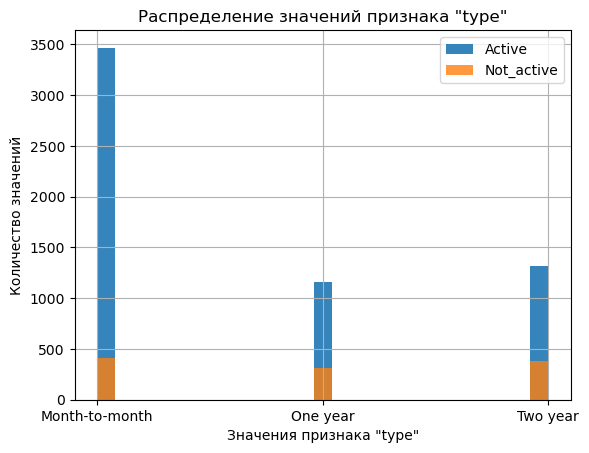

,count,unique,top,freq
Active,5942,2,Yes,3450
Not_active,1101,2,Yes,721


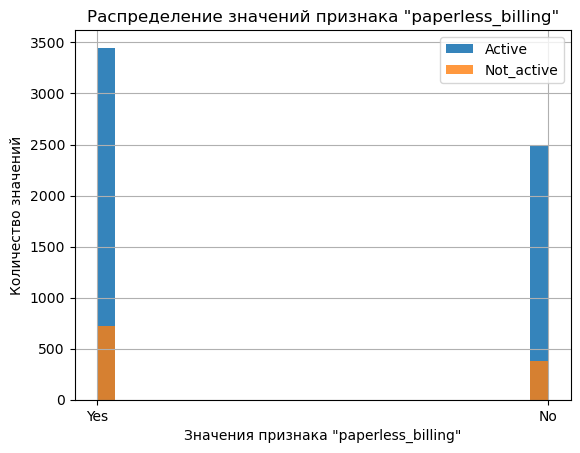

,count,unique,top,freq
Active,5942,4,Electronic check,2015
Not_active,1101,4,Electronic check,350


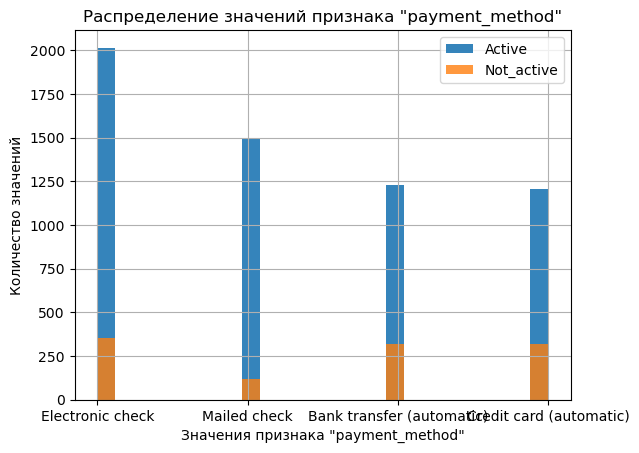

,count,unique,top,freq
Active,5942,1,Active,5942
Not_active,1101,1,Not_active,1101


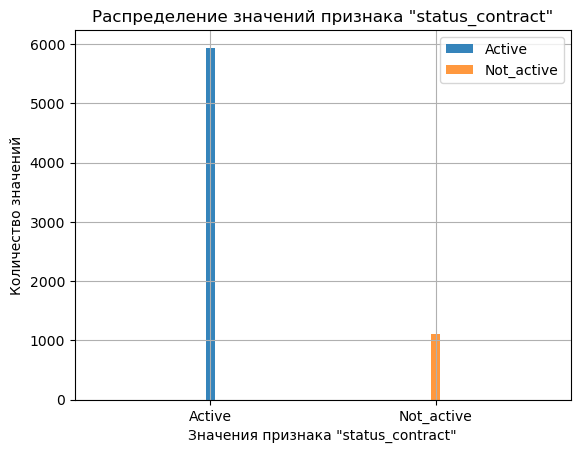

In [28]:
# Анализ категориальных признаков 
for i in ['type', 'paperless_billing', 'payment_method', 'status_contract']:
    
                x0 = data.loc[data['status_contract'] == 'Active', i] 
                x1 = data.loc[data['status_contract'] == 'Not_active', i] 
                
                x0 = x0.rename('Active') 
                x1 = x1.rename('Not_active') 
                
                display(pd.DataFrame([x0.describe(), x1.describe()])) 
                
                x0.hist(legend=True, alpha=.9, bins=25)
                x1.hist(legend=True, alpha=.8, bins=25) 
                plt.title(f'Распределение значений признака "{i}"')
                plt.xlabel(f'Значения признака "{i}"')
                plt.ylabel('Количество значений')
                plt.show() 

### Вывод: 

1. Самый популярный способ оплаты это ежемесячные платежи `(type)`
2. Более половины пользователей используют, `электронный расчетный лист (paperless_billing)`
3. Признак `payment_method`, содержит 4 варианта оплаты, самый популярный способ - электронный чек.
4. Из представленных данных мы видим 5942 активных контракта и 1101 расторгнутых



,count,unique,top,freq
Active,5942,2,Male,2982
Not_active,1101,2,Male,573


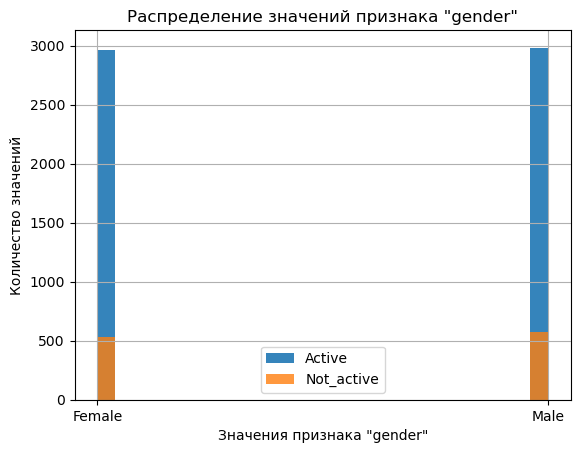

,count,unique,top,freq
Active,5942,2,No,5032
Not_active,1101,2,No,869


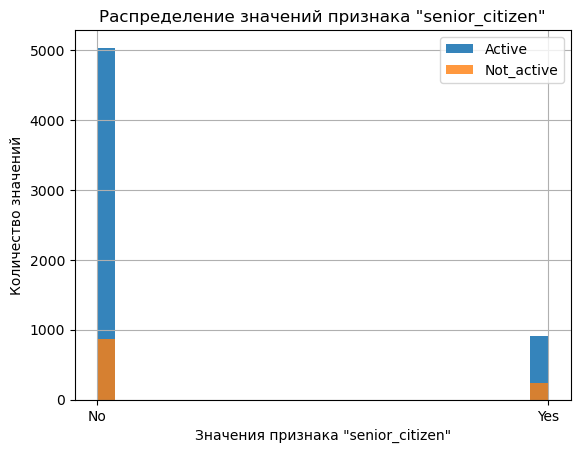

,count,unique,top,freq
Active,5942,2,No,3259
Not_active,1101,2,Yes,719


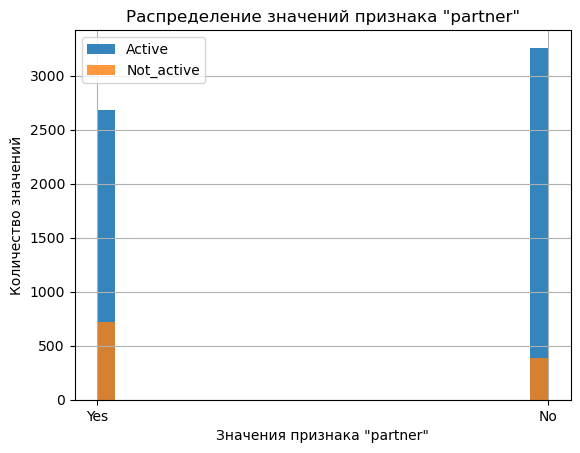

,count,unique,top,freq
Active,5942,2,No,4200
Not_active,1101,2,No,733


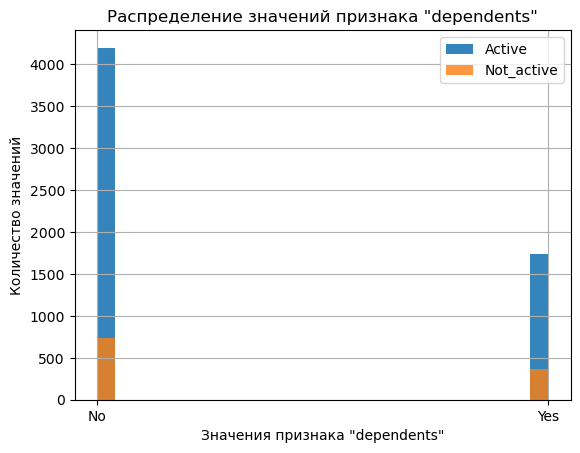

In [29]:
# Анализ категориальных признаков 
for i in ['gender', 'senior_citizen', 'partner', 'dependents']:
    
                x0 = data.loc[data['status_contract'] == 'Active', i] 
                x1 = data.loc[data['status_contract'] == 'Not_active', i] 
                
                x0 = x0.rename('Active') 
                x1 = x1.rename('Not_active') 
                
                display(pd.DataFrame([x0.describe(), x1.describe()])) 
                
                x0.hist(legend=True, alpha=.9, bins=25)
                x1.hist(legend=True, alpha=.8, bins=25) 
                plt.title(f'Распределение значений признака "{i}"')
                plt.xlabel(f'Значения признака "{i}"')
                plt.ylabel('Количество значений')
                plt.show() 

### Вывод:
Рассмотрев распределение значений признаков  в части информации о пользователях можно сделать вывод:
1. По половому признаку `(gender)` нет явных отличий , мужчин и жещин практически поровну. 
2. Распределение признака `(senior_citizen)` говорит о том, что пенсионеров значительно меньшее число среди пользователей.
3. Распределение признака `(partner)` говорит о том что пользователей не состоящих в браке большее число и так же они реже рассторгают контракт.
4. Признак `(dependents)`- наличие детей, указывает что у большинства пользователей детей нет

Портрет целевого клиента выглядит так: это молодой человек или девушка не состоит в браке, без детей. Очень похоже что возраст клиентов от 25-35 лет(т.к. почти половина состоит в браке и примерно 30% из них имеют детей).

Руководству компании стоит рассмотреть возможность разработки коммерческих предложений для более взрослой категории людей, чтобы увеличить клиентский охват и выручку. 

,count,unique,top,freq
Active,5942,3,Fiber optic,2501
Not_active,1101,3,Fiber optic,595


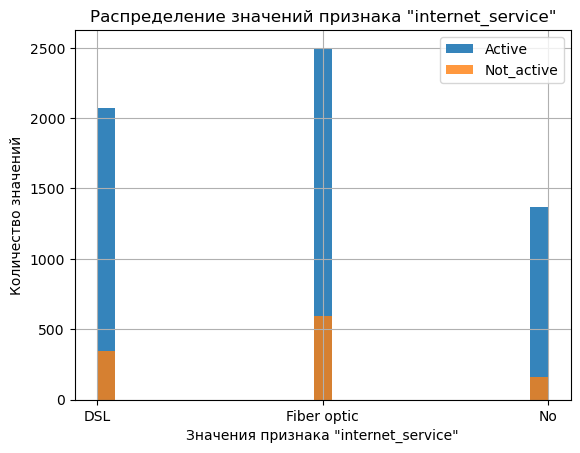

,count,unique,top,freq
Active,5942,2,No,4338
Not_active,1101,2,No,686


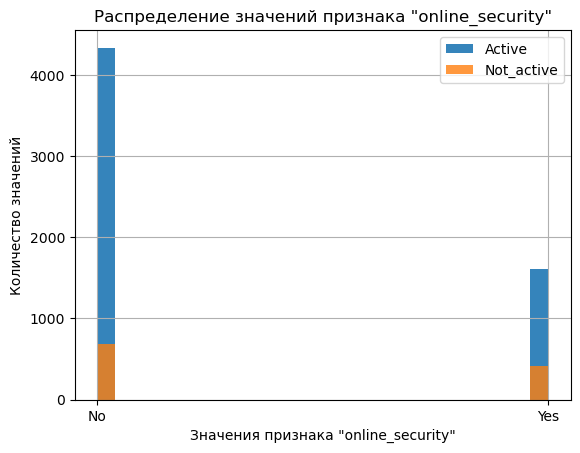

,count,unique,top,freq
Active,5942,2,No,4073
Not_active,1101,2,Yes,560


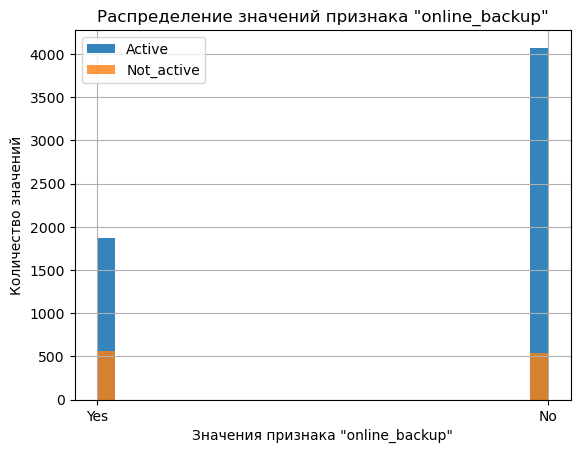

,count,unique,top,freq
Active,5942,2,No,4070
Not_active,1101,2,No,551


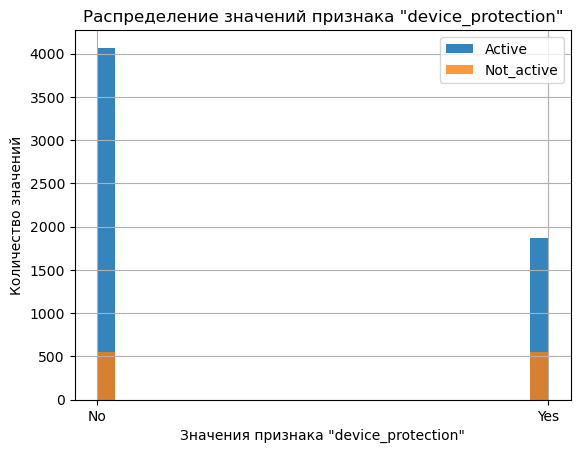

,count,unique,top,freq
Active,5942,2,No,4296
Not_active,1101,2,No,703


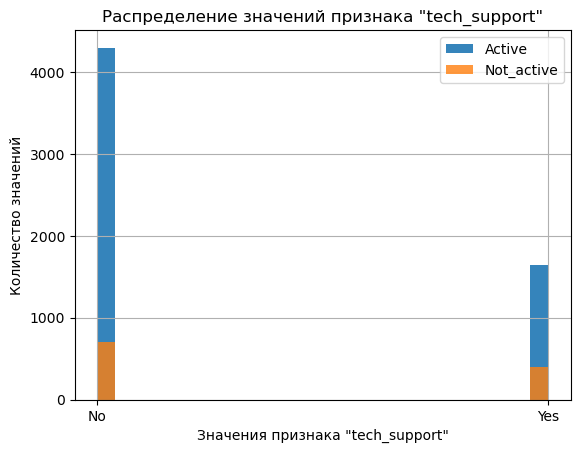

,count,unique,top,freq
Active,5942,2,No,3819
Not_active,1101,2,Yes,584


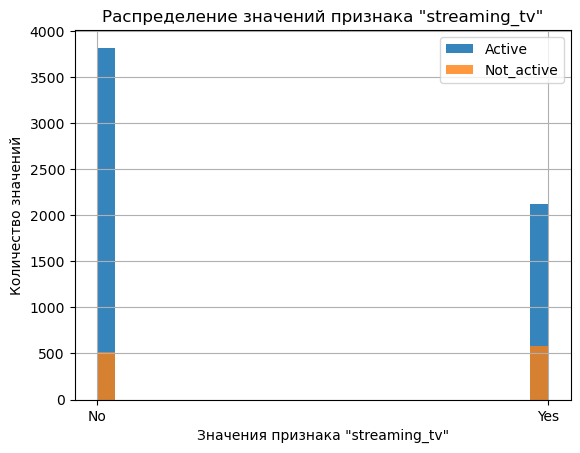

,count,unique,top,freq
Active,5942,2,No,3816
Not_active,1101,2,Yes,606


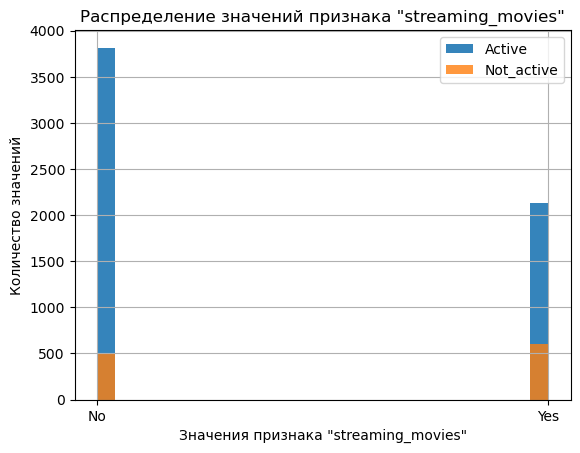

,count,unique,top,freq
Active,5942,2,No,3649
Not_active,1101,2,Yes,678


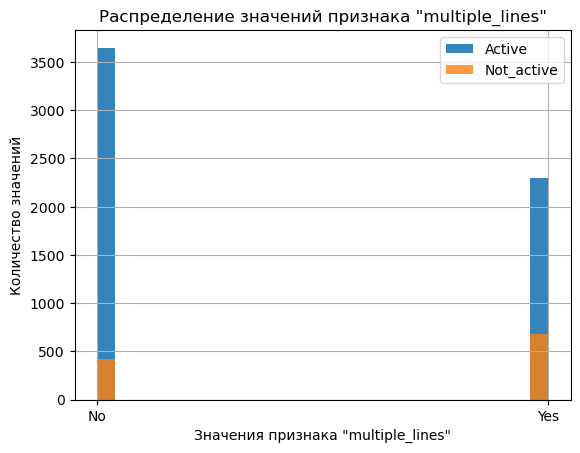

In [30]:
# Анализ категориальных признаков 
for i in ['internet_service', 'online_security','online_backup', 'device_protection', \
          'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']:
    
                x0 = data.loc[data['status_contract'] == 'Active', i] 
                x1 = data.loc[data['status_contract'] == 'Not_active', i] 
                
                x0 = x0.rename('Active') 
                x1 = x1.rename('Not_active') 
                
                display(pd.DataFrame([x0.describe(), x1.describe()]))
                
                x0.hist(legend=True, alpha=.9, bins=25)
                x1.hist(legend=True, alpha=.8, bins=25) 
                plt.title(f'Распределение значений признака "{i}"')
                plt.xlabel(f'Значения признака "{i}"')
                plt.ylabel('Количество значений')
                plt.show() 

### Вывод:
Рассмотрим баланс категориальных признаков в части распределения предоставляемых услуг.
1. По типу интернет подключения `(internet_service)` большее число пользователей предпочитает оптиковолоконное соединение. Также мы можем увидеть большое число клиентов около (1400) которые не подключили себе данную услугу. Возможно стоит разослать им рекламные предложения для оказания данной услуги.
2. Услуга блокировки опасных сайтов `(Online_security)` не самая популярная, т.к. её используют около 25% клиентов. 
3. Более 4000 пользователей не используют облачное хранение данных `(Online_backup)`
4. Антивирус `(device_protection)` 4070 пользователей из числа тех кто не расторг контракт не подключил себе услугу "Антивирус"
5. Выделенную линию поддержки `(tech_support)` не используют 4296 пользователей 
6. Стриминговое телевидение `(streaming_tv)` не используют 3819 пользователей
7. Каталог фильмов `(streaming_movies)` большая часть пользователей (3816) не подключили данную услугу
8. 3649 пользователей из числа "активных контрактов" не подключены к нескольким телефонным линиям `multiple_lines`


В целом можно отметить, что дополнительные услуги не пользуются большой популярностью у клиентов или отдел маркетинга не рассылает им достаточное количество информационных материалов, что клиенты не вкурсе о существовании дополнительных услуг.

## Количественные признаки
Визуализируем количественные признаки

,count,unique,top,freq,first,last
Active,5942,76,2014-02-01,265,2013-10-01,2020-02-01
Not_active,1101,69,2014-02-01,101,2013-12-01,2019-10-01


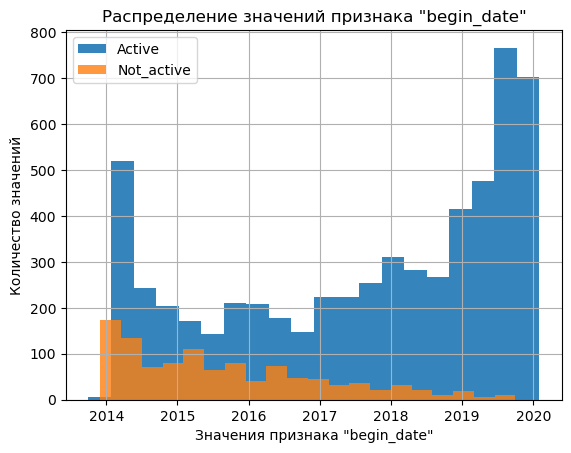

,count,mean,std,min,25%,50%,75%,max
Active,5942.0,62.763455,29.844462,18.25,30.0625,69.2,87.2375,118.60
Not_active,1101.0,75.546004,29.116213,18.40,56.1500,84.2,99.5000,118.75


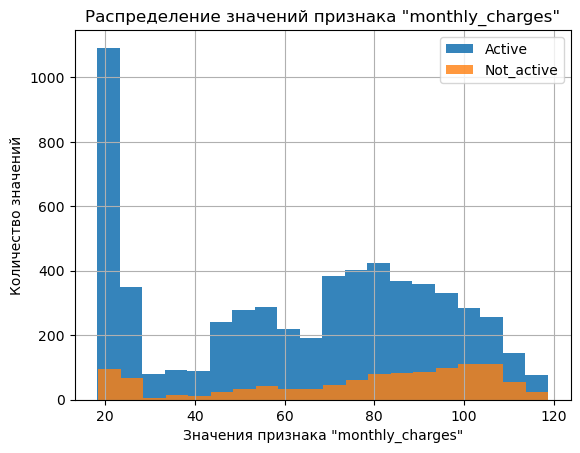

,count,mean,std,min,25%,50%,75%,max
Active,5942.0,2067.943095,2193.827140,19.05,374.3525,1192.80,3173.8375,9221.38
Not_active,1101.0,2371.377275,1581.862275,77.84,1048.0500,2139.03,3404.9100,7649.76


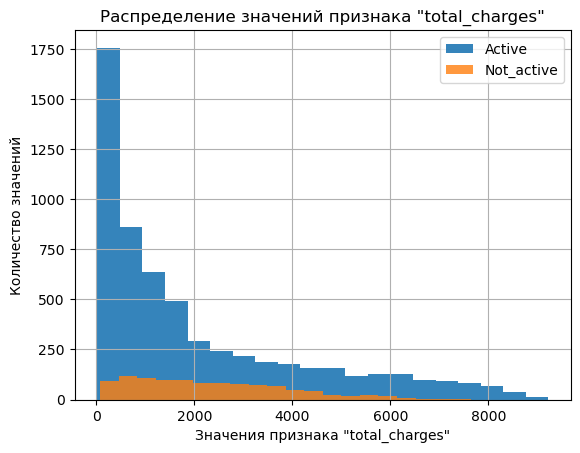

,count,mean,std,min,25%,50%,75%,max
Active,5942.0,893.681084,716.958551,0.0,245.0,702.0,1523.0,2314.0
Not_active,1101.0,924.863760,458.771309,28.0,577.0,915.0,1249.0,2129.0


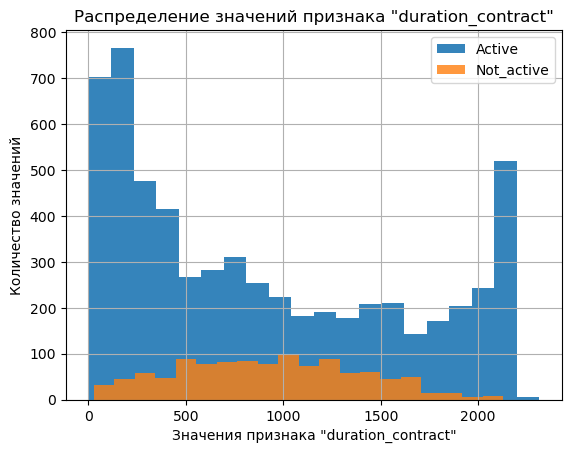

In [31]:
# Анализ количественных признаков 
for i in ['begin_date', 'monthly_charges', 'total_charges', \
          'duration_contract']:
    
                x0 = data.loc[data['status_contract'] == 'Active', i] 
                x1 = data.loc[data['status_contract'] == 'Not_active', i] 
                
                x0 = x0.rename('Active') 
                x1 = x1.rename('Not_active') 
                
                display(pd.DataFrame([x0.describe(), x1.describe()])) 
                
                x0.hist(legend=True, alpha=.9, bins=20)
                x1.hist(legend=True, alpha=.8, bins=20)
                plt.title(f'Распределение значений признака "{i}"')
                plt.xlabel(f'Значения признака "{i}"')
                plt.ylabel('Количество значений')
                plt.show() 

Проверим частосту оттока пользователей.

,count,unique,top,freq,first,last
Not_active,1101,66,2020-01-01,39,2014-06-01,2020-01-01


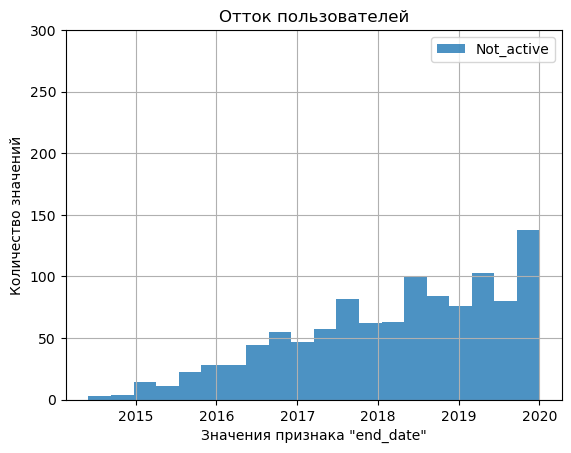

In [32]:
for i in ['end_date']:
    x1 = data.loc[data['status_contract'] == 'Not_active', i] 
    x1 = x1.rename('Not_active') 
    display(pd.DataFrame([x1.describe()])) 
    
    x1.hist(legend=True, alpha=.8, bins=20)
    
    plt.title(f'Отток пользователей')
    plt.xlabel(f'Значения признака "{i}"')
    plt.ylabel('Количество значений')
    plt.ylim(0, 300)
    plt.show() 

На графике оттока пользователей видно что с каждым годом отток пользователей увеличивается, это не страшно потому что в целом увеличивается число новых пользователей, начиная со второй половины 2017 года. 

### Вывод:
На графике распределения значений begin_data(дата начала контракта) Заметны два пиковых значения, первый пик пиходится на 2014 год, вероятно это было открытие компании "ТелеДом". С середины 2014 года по середину 2017 года прирост новых пользователей в среднем составлял 200 человек. Начиная со второй половины 2017 года по настоящее время (2020-02-01) виден прироста новых клиентов, так же заметно что с каждым годом количетсво расторжений контракта снижается, это очень радует.

На графике распределения пользователей по ежемесячным платежам видно 3 пиковых значения. вероятнее всего это разные пакетные тарифные планы. так же можно заметить - "дивергенцию", на графике начиная с 80 у.е в месяц начинает расти количество пользователей которуе уходят. (В этом случае рекоммендую подключать дополнительные услуги пользователям которые платят более 80 у.е. в месяц, чтобы расширить включенные пакетные услуги. или разработать новый тарифный план - XXL который в который будут включены широкий выбор дополнительных услуг)

По распределению общей выручки total_charges видно, что большая выручка приходится на пользователей которые которые принесли общую выручку от 0 до 2000 рублей. Это все относительно новые пользователи которые подключились с середины 2017 года отчетливо видна кореляция с признаком begin_data

Признак duration_contract практически зеркальное отражение признака begin_data. Он показывает количество дней действия контракта. Видны пиковые значения в районе 500, 1000 дней, когда пользователи расторгают контракт. начиная с 1000 дней пользования услугами, расторжения контрактов уменьшается и практически сводится к нулю в районе 2000 дней.

## Проверка на аномалии

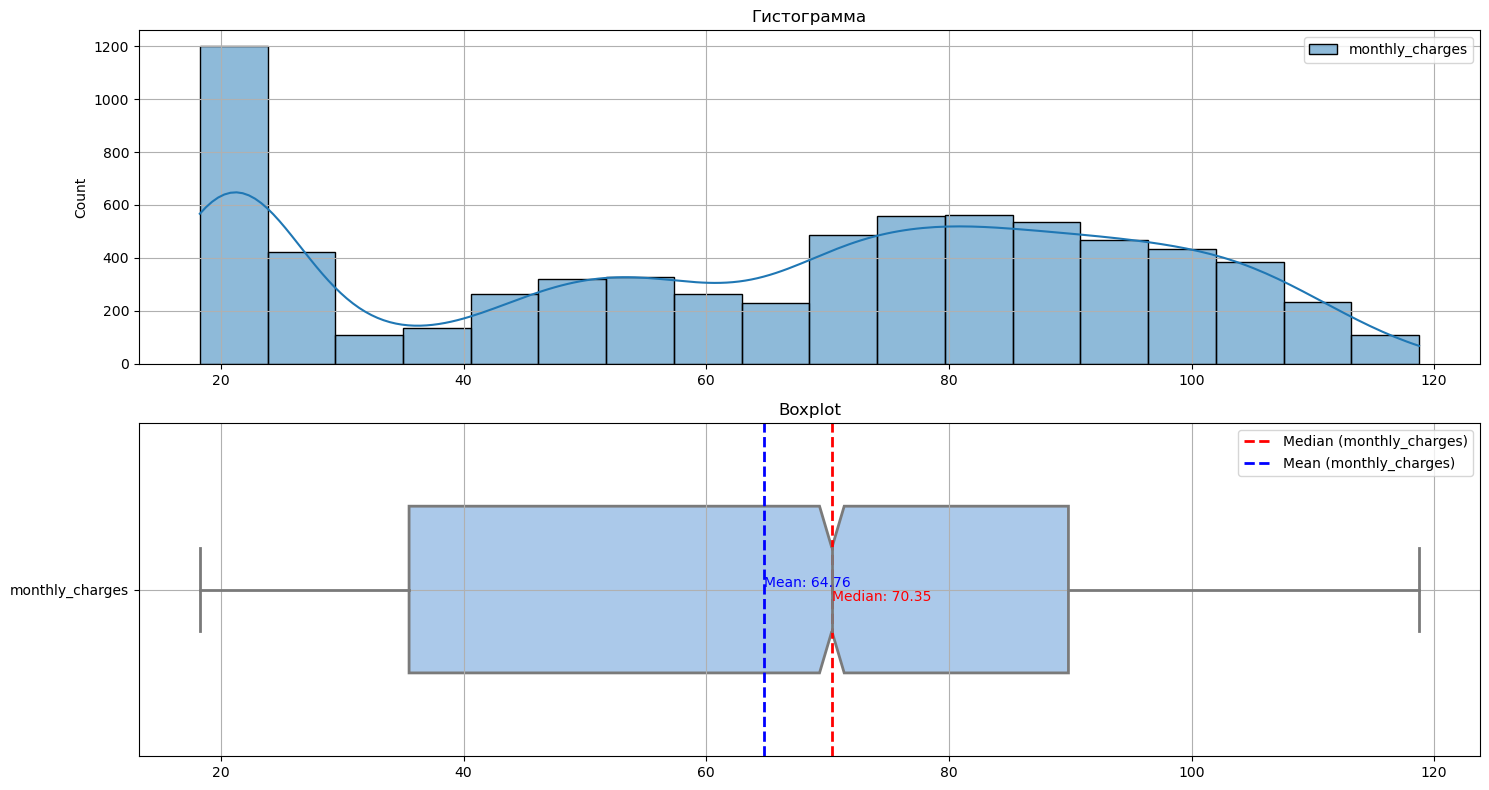

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: monthly_charges, dtype: float64

In [33]:
plot_distribution_summary(data, 'monthly_charges')
display(data['monthly_charges'].describe())

Тут всё хорошо, выбросов нет.

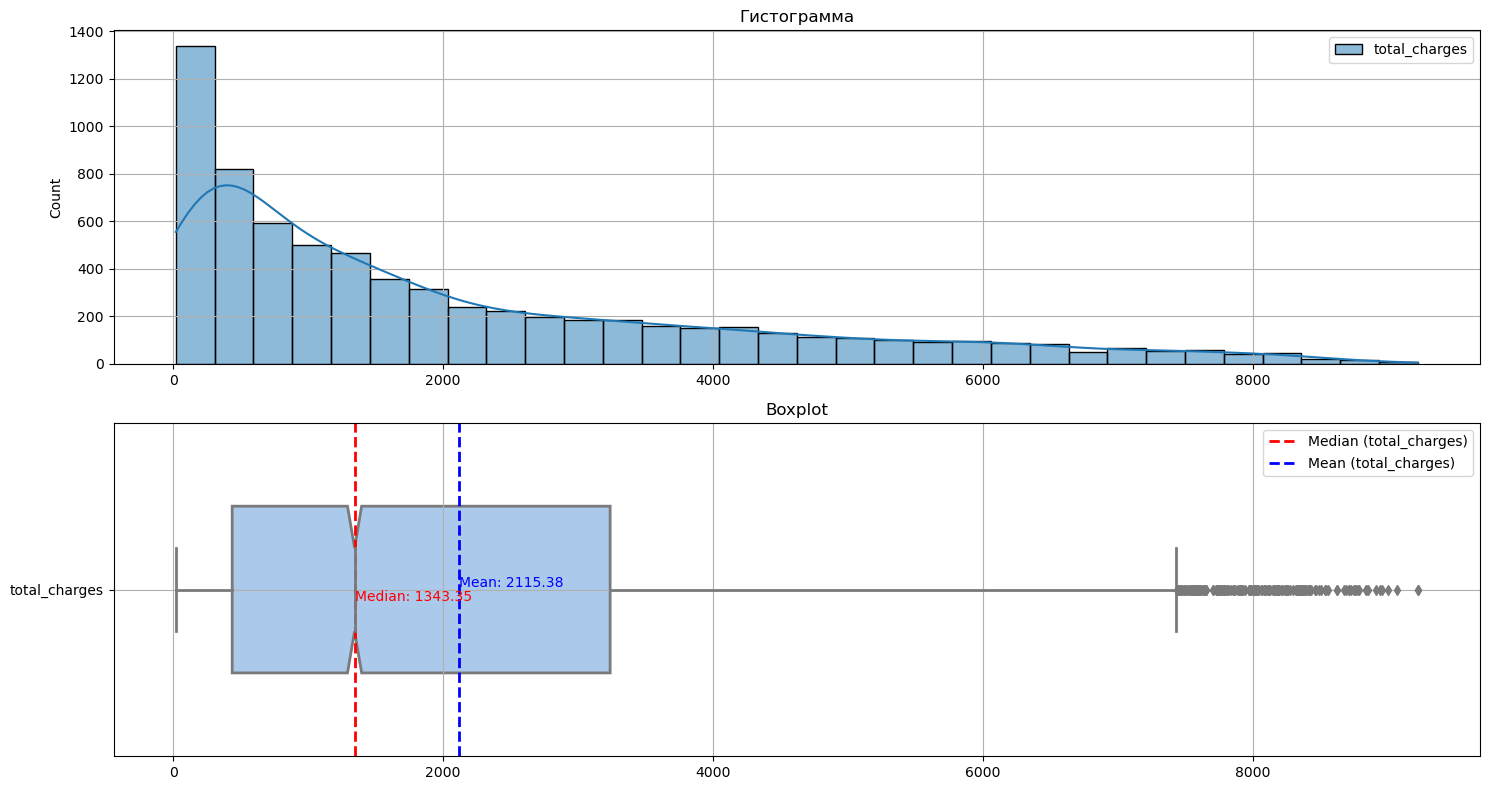

count    7043.000000
mean     2115.377573
std      2112.678861
min        19.050000
25%       436.750000
50%      1343.350000
75%      3236.690000
max      9221.380000
Name: total_charges, dtype: float64

In [34]:
plot_distribution_summary(data, 'total_charges')
display(data['total_charges'].describe())

### Вывод:
- 1 квартиль - 436
- Медианное значение - 1343
- 3 квартиль - 3236
- Ср. арифметическое - 2115

Большая часть данных распределена между 1 квартилем и 3 квартилем. , также данные имеют длинный "хвост". Чтобы это не мешало обучению, нужно их унифицировать с помощью StandardScaler().

## Кореляционный анализ
Воспользуемся библиотекой phik для оценки корреляции различных гиперпараметров между собой.

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'duration_contract']


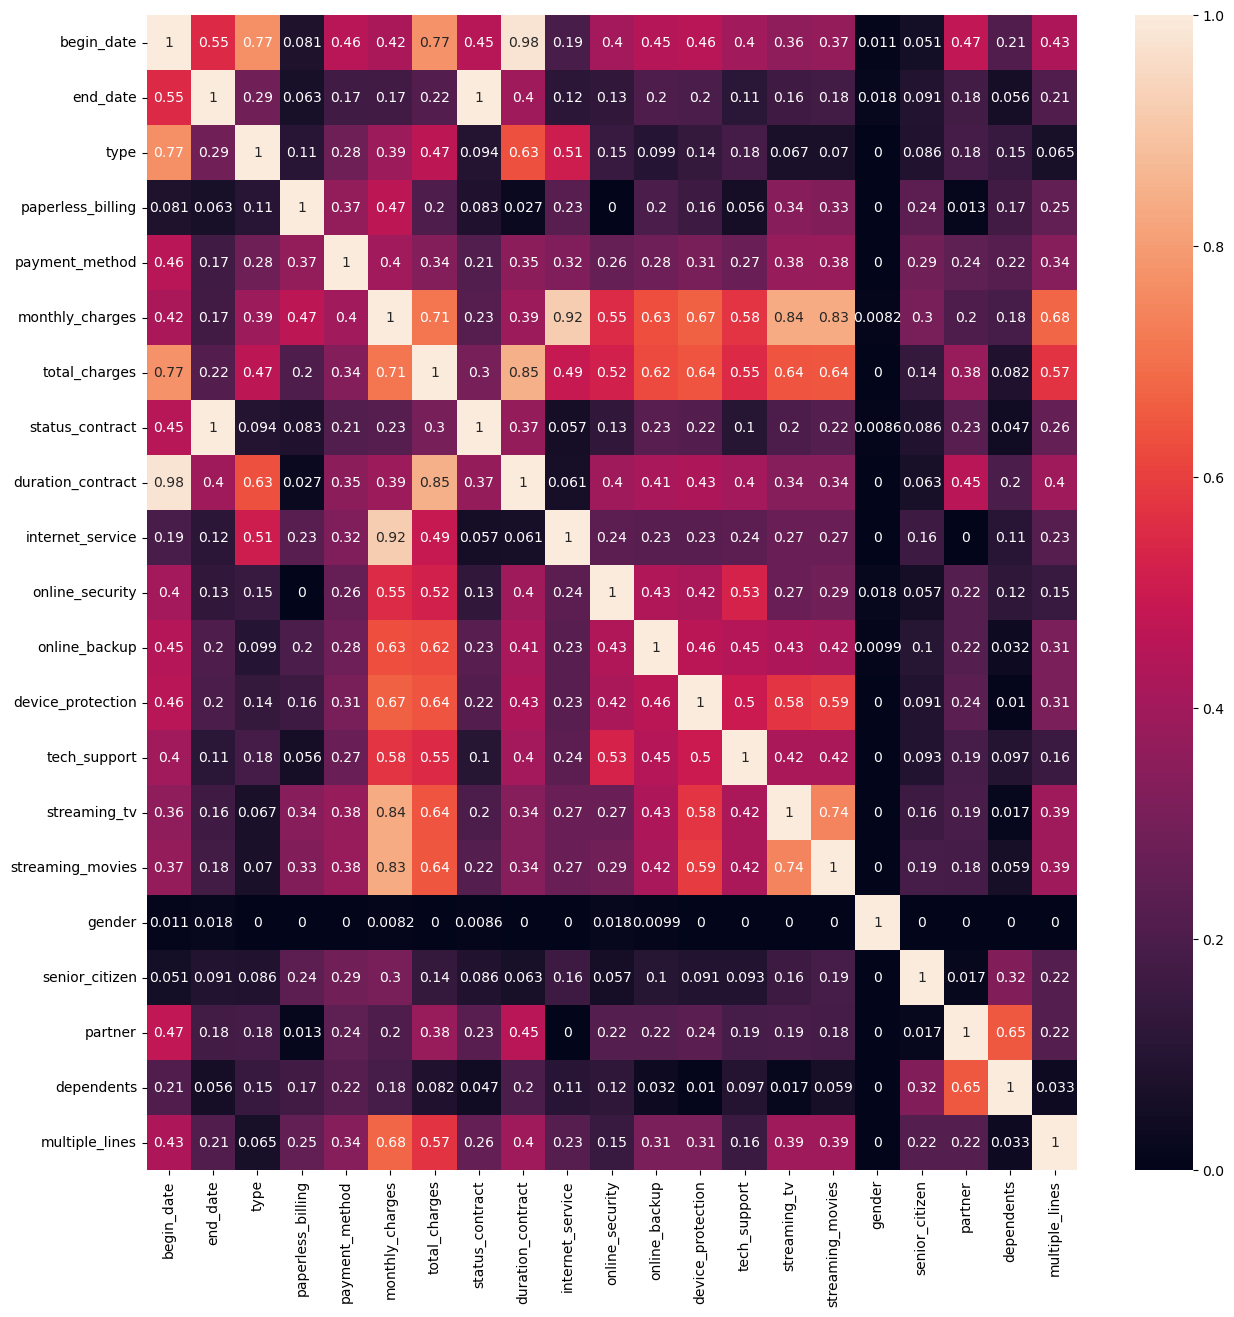

In [35]:
# Удаление лишнего признака
data = data.drop(['customer_id'], axis=1)

# Построение тепловой карты 
corr_matrix = data.phik_matrix()

plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True);

На тепловой карте видно, что у нас высокая корреляция между признаком end_date и status_contract(Таргет), что логично, учитывая, что эти показатели идентичны. Аналогичная ситуация с begin_date и duration_contract.

Также высокая корреляция наблюдается между показателями duration_contract и total_charges.

Признак gender позал отсутствие корреляции почти со всеми показателями. Скорее всего данный признак не даст какого-либо прироста метрики моделей машинного обучения. Мы можем его удалить.

Также удалим мультиколлинеарные признаки customer_id, begin_date и end_date.

### Вывод:
В исследовательском анализе мы рассмотрели все признаки и сравнили их с таргетом, и пришли к выводу что:
    
- 5942 активных контракта и 1101 расторгнутых;
- Портрет целевого клиента выглядит так: это молодой человек или девушка не состоит в браке, без детей. Очень похоже что возраст клиентов от 25-35 лет(т.к. почти половина состоит в браке и примерно 30% из них имеют детей). Руководству компании стоит рассмотреть возможность разработки коммерческих предложений для более взрослой категории людей, чтобы увеличить клиентский охват и выручку.
- Большая часть клиентов не пользуются дополнительными услугами: отделу маркетинга следует распространить ифнормацию до клиентов с предложением подключить дополнительные услуги.
- Начиная со второй половины 2017 года по настоящее время (2020-02-01) заметен прироста новых клиентов, так же заметно что с каждым годом количетсво расторжений контракта снижается, это очень радует.
- На графиках видно что пользователи которые платят более 80 у.е. расторгают контракт. Чтобы это предотвратить рекомендую (разработать новый тарифный план - XXL который в который будут включены широкий выбор дополнительных услуг).
- Чаще всего пользователи расторгают контракт на 500 день пользования и на 1000. (Рекомендую разработать маркетинговые акции удержания в этот период).
- Корреляционный анализ показал зависимость таких признаков, как:

    * end_date и target;
    * begin_date и duration_contract;
    * montly_charges и internet_service.
    
Признак gender не коррелирует ни с одним из других фичей, в связи с чем мы можем удалить его из датасета на этапе подготовки данных для обучения.

# Подготовка данных к обучению

### Удаление лишних признаков
Удалим признаки, которые помешают модели обучиться.

In [36]:
data = data.drop(columns=[
    'end_date',
    'begin_date',
    'gender'], axis=1)
data.columns

Index(['type', 'paperless_billing', 'payment_method', 'monthly_charges',
       'total_charges', 'status_contract', 'duration_contract',
       'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'senior_citizen', 'partner', 'dependents', 'multiple_lines'],
      dtype='object')

### Разделение датасета на обучающую и тестовую выборки

Разделим на признаки и таргет:

In [37]:
features = data.drop('status_contract', axis=1)
target = data['status_contract']

display(features.shape)
display(target.shape)
display(features.head())

(7043, 17)

(7043,)

,type,paperless_billing,payment_method,monthly_charges,total_charges,duration_contract,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,senior_citizen,partner,dependents,multiple_lines
0,Month-to-month,Yes,Electronic check,29.85,31.04,31,DSL,No,Yes,No,No,No,No,No,Yes,No,No
1,One year,No,Mailed check,56.95,2071.84,1036,DSL,Yes,No,Yes,No,No,No,No,No,No,No
2,Month-to-month,Yes,Mailed check,53.85,226.17,123,DSL,Yes,Yes,No,No,No,No,No,No,No,No
3,One year,No,Bank transfer (automatic),42.30,1960.60,1371,DSL,Yes,No,Yes,Yes,No,No,No,No,No,No
4,Month-to-month,Yes,Electronic check,70.70,353.50,153,Fiber optic,No,No,No,No,No,No,No,No,No,No


In [38]:
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    target,
                                                    test_size=0.25,
                                                    random_state=RANDOM_STATE)

display(X_train.shape)
display(X_test.shape)
display(y_train.shape)
display(y_test.shape)

(5282, 17)

(1761, 17)

(5282,)

(1761,)

### Кодирование категориальных признаков
Методом OneHotEncoding проведем кодирование

In [39]:
# Сброс индексов для избежания появления NAN при join датасетов
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

ohe_columns = []

# Сбор категориальных признаков через цикл в список
for column in X_train.columns:
    if X_train[column].dtypes == object:
        ohe_columns.append(column)

# Обучение энкодера
encoder = OneHotEncoder(drop='first').fit(X_train[ohe_columns])
new_columns = encoder.get_feature_names(ohe_columns)

# Кодирование категориальных признаков, сбор train выборки
encoder_train = pd.DataFrame(encoder.transform(X_train[ohe_columns]).toarray(),
                             columns=new_columns)

X_train = X_train.join(encoder_train)
X_train = X_train.drop(columns=ohe_columns, axis=1)
display(X_train)

# Кодирование категориальных признаков, сбор test выборки
encoder_test = pd.DataFrame(encoder.transform(X_test[ohe_columns]).toarray(),
                            columns=new_columns)

X_test = X_test.join(encoder_test)
X_test = X_test.drop(columns=ohe_columns, axis=1)
display(X_test)

,monthly_charges,total_charges,duration_contract,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,internet_service_Fiber optic,...,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,senior_citizen_Yes,partner_Yes,dependents_Yes,multiple_lines_Yes
0,104.60,3138.00,914,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
1,93.55,4104.04,1249,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,62.50,4455.00,2010,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
3,105.50,4473.20,1219,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
4,19.65,255.45,396,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5277,79.60,525.36,184,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
5278,55.95,830.30,427,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
5279,109.80,4831.20,1340,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
5280,54.45,3813.68,2071,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,monthly_charges,total_charges,duration_contract,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,internet_service_Fiber optic,...,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,senior_citizen_Yes,partner_Yes,dependents_Yes,multiple_lines_Yes
0,20.75,532.86,730,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,65.65,4618.48,2041,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,58.60,3351.92,1676,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,80.80,404.00,153,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
4,92.70,1575.90,518,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1756,19.85,168.33,245,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1757,58.65,4164.15,2163,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
1758,73.50,5688.16,2163,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
1759,59.95,857.29,396,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


### Вывод:
На данном этапе мы удалили признаки которые будут мешать обучению модели: `begin_date`, `end_date`, `gender`. А также закодировали категориальные признаки.

# Обучение моделей
Обучим несколько моделей на данных и посмотрим на метрику AUC-ROC.

Собирем пайплайны для каждой модели. В нем будет scaler и модель. Сетку параметров укажем в словаре param_grid. Обучим модели через GridSearchCV с помощью кросс-валидации.

Для обучения будем использовать следующие модели:

- LogisticRegression
- RandomForestClassifier
- LGBMClasifier
- CatBoostClassifier

### LogisticRegression

In [40]:
pipeline = Pipeline([("scaler", StandardScaler()),
                     ("lr", LogisticRegression(random_state=RANDOM_STATE,
                                               class_weight='balanced'))])

param_grid = {
    'lr__solver': ['lbfgs', 'liblinear'],
    'lr__C': range(1, 10)
}

grid_pipeline = GridSearchCV(pipeline,
                             param_grid,
                             verbose=1,
                             cv=5,
                             n_jobs=-1,
                             scoring='roc_auc')

grid_pipeline.fit(X_train, y_train)
display(grid_pipeline.best_params_)
display(grid_pipeline.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


{'lr__C': 4, 'lr__solver': 'lbfgs'}

0.7592086497658257

### RandomForestClassifier

In [41]:
pipeline = Pipeline([("scaler", StandardScaler()),
                     ("rfc", RandomForestClassifier(random_state=RANDOM_STATE,
                                                    class_weight='balanced'))])

param_grid = {
    'rfc__max_depth': range (2, 10),
    'rfc__n_estimators': range (10, 20),
    'rfc__min_samples_split': range(2, 5),
    'rfc__min_samples_leaf': range(1, 3)
}

grid_pipeline = GridSearchCV(pipeline,
                             param_grid,
                             verbose=1,
                             n_jobs=-1,
                             cv=5,
                             scoring='roc_auc')

grid_pipeline.fit(X_train, y_train)
display(grid_pipeline.best_params_)
display(grid_pipeline.best_score_)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


{'rfc__max_depth': 7,
 'rfc__min_samples_leaf': 1,
 'rfc__min_samples_split': 2,
 'rfc__n_estimators': 19}

0.8061865280215221

### LGBMClassifier

In [42]:
pipeline = Pipeline([("scaler", StandardScaler()),
                    ("lgbm", LGBMClassifier(random_state=RANDOM_STATE,
                                                  class_weight='balanced'))])

param_grid = {
    'lgbm__max_depth': range(5, 10),
    'lgbm__n_estimators': range(15, 20),
    'lgbm__max_leaf_nodes': range(2, 5)
}

grid_pipeline = GridSearchCV(pipeline,
                             param_grid,
                             verbose=1,
                             n_jobs=-1,
                             cv=5,
                             scoring='roc_auc')

grid_pipeline.fit(X_train, y_train)
display(grid_pipeline.best_params_)
display(grid_pipeline.best_score_)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=2 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=2 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 828, number of negative: 4454
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 747
[LightGBM] [Info] Number of data points in the train set: 5282, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg

{'lgbm__max_depth': 6, 'lgbm__max_leaf_nodes': 2, 'lgbm__n_estimators': 19}

0.8141622435650436

### CatboostClassifier

In [43]:
pipeline = Pipeline([("cbc", CatBoostClassifier(random_state=RANDOM_STATE,
                                                loss_function="Logloss",
                                                auto_class_weights='Balanced'))])

param_grid = {
    'cbc__learning_rate': [0.01, 0.1],
    'cbc__depth': [1, 10]
}

grid_pipeline = GridSearchCV(pipeline,
                             param_grid,
                             verbose=1,
                             cv=5,
                             scoring='roc_auc')

grid_pipeline.fit(X_train, y_train)
display(grid_pipeline.best_params_)
display(grid_pipeline.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
0:	learn: 0.6924484	total: 138ms	remaining: 2m 17s
1:	learn: 0.6918887	total: 140ms	remaining: 1m 9s
2:	learn: 0.6913985	total: 141ms	remaining: 47s
3:	learn: 0.6907551	total: 143ms	remaining: 35.6s
4:	learn: 0.6901636	total: 144ms	remaining: 28.7s
5:	learn: 0.6895674	total: 146ms	remaining: 24.2s
6:	learn: 0.6889846	total: 148ms	remaining: 21s
7:	learn: 0.6883250	total: 149ms	remaining: 18.5s
8:	learn: 0.6878581	total: 151ms	remaining: 16.6s
9:	learn: 0.6873543	total: 152ms	remaining: 15s
10:	learn: 0.6868585	total: 153ms	remaining: 13.8s
11:	learn: 0.6864981	total: 155ms	remaining: 12.7s
12:	learn: 0.6858286	total: 156ms	remaining: 11.9s
13:	learn: 0.6852751	total: 157ms	remaining: 11.1s
14:	learn: 0.6848224	total: 159ms	remaining: 10.4s
15:	learn: 0.6841761	total: 160ms	remaining: 9.83s
16:	learn: 0.6836763	total: 161ms	remaining: 9.32s
17:	learn: 0.6833382	total: 162ms	remaining: 8.86s
18:	learn: 0.6826740	total: 164ms	rem

{'cbc__depth': 10, 'cbc__learning_rate': 0.1}

0.8572741549433335

### Проверка лучшей модели на тестовой выборке

In [44]:
model = CatBoostClassifier(random_state=RANDOM_STATE,
                           loss_function="Logloss",
                           auto_class_weights='Balanced',
                           depth=10,
                           learning_rate=0.1)

model.fit(X_train, y_train)
predictions = model.predict(X_test)
predictions_proba = model.predict_proba(X_test)[:, 1]

display(roc_auc_score(y_test, predictions_proba))
display(accuracy_score(y_test, predictions))

0:	learn: 0.6522343	total: 22.5ms	remaining: 22.5s
1:	learn: 0.6127601	total: 43.6ms	remaining: 21.8s
2:	learn: 0.5853842	total: 65.9ms	remaining: 21.9s
3:	learn: 0.5617471	total: 86.4ms	remaining: 21.5s
4:	learn: 0.5414525	total: 107ms	remaining: 21.4s
5:	learn: 0.5214221	total: 129ms	remaining: 21.4s
6:	learn: 0.5066810	total: 150ms	remaining: 21.3s
7:	learn: 0.4969684	total: 171ms	remaining: 21.2s
8:	learn: 0.4847208	total: 193ms	remaining: 21.2s
9:	learn: 0.4740926	total: 215ms	remaining: 21.3s
10:	learn: 0.4632919	total: 240ms	remaining: 21.6s
11:	learn: 0.4615249	total: 243ms	remaining: 20s
12:	learn: 0.4540278	total: 270ms	remaining: 20.5s
13:	learn: 0.4456835	total: 291ms	remaining: 20.5s
14:	learn: 0.4335368	total: 312ms	remaining: 20.5s
15:	learn: 0.4230131	total: 334ms	remaining: 20.6s
16:	learn: 0.4172655	total: 355ms	remaining: 20.6s
17:	learn: 0.4112223	total: 377ms	remaining: 20.6s
18:	learn: 0.4014079	total: 398ms	remaining: 20.5s
19:	learn: 0.3957182	total: 419ms	remai

0.8818164362519201

0.8830210107893243

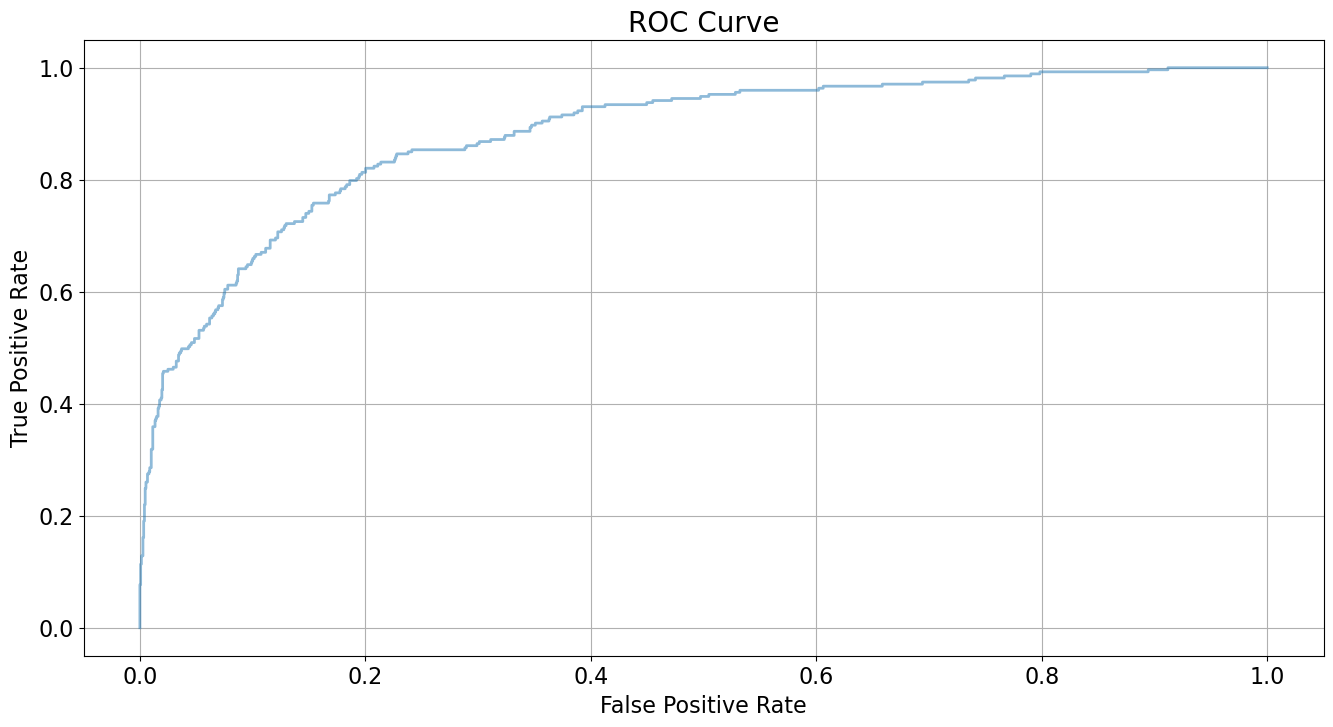

In [45]:
catboost_pool = Pool(X_test, y_test)
(fpr, tpr, thresholds) = get_roc_curve(model, catboost_pool, plot=True)

ROC кривая выгнута вверх, это подтверждает что модель в большинстве случаев правильно предсказывает таргет.

In [46]:
features_imp = pd.DataFrame(model.get_feature_importance(), X_test.columns)
features_imp

,0
monthly_charges,9.333241
total_charges,10.577673
duration_contract,23.974234
type_One year,4.442339
type_Two year,4.897819
paperless_billing_Yes,3.376335
payment_method_Credit card (automatic),2.656427
payment_method_Electronic check,3.013803
payment_method_Mailed check,2.705413
internet_service_Fiber optic,1.274942


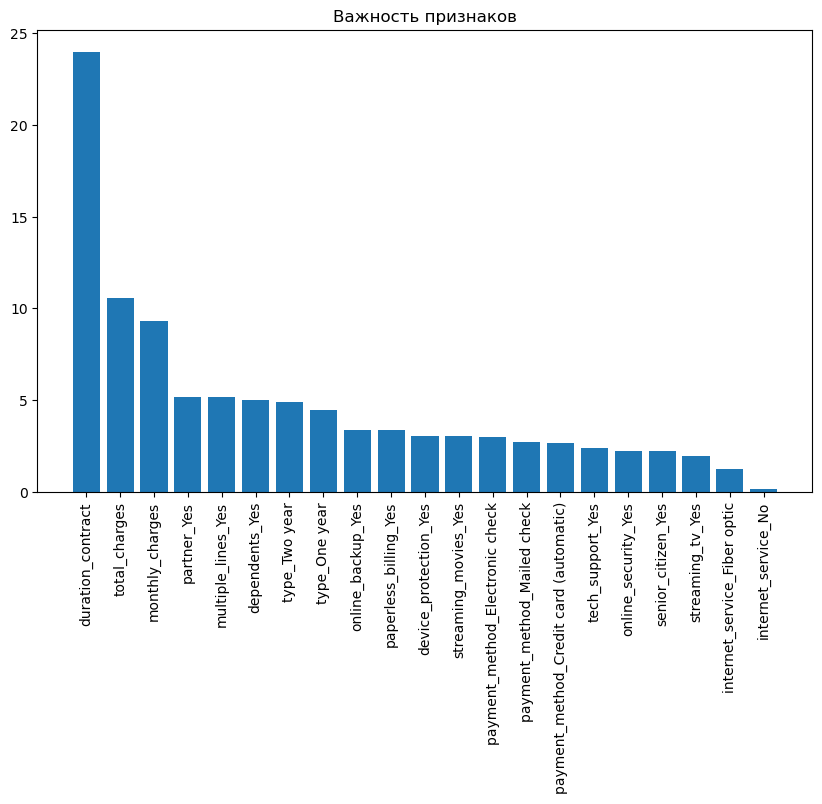

In [47]:
importances = model.get_feature_importance()
feature_names = X_test.columns
sorted_indices = np.argsort(importances)[::-1]
 
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_names)), importances[sorted_indices])
plt.xticks(range(len(feature_names)), feature_names[sorted_indices], rotation=90)
plt.title("Важность признаков")
plt.show()

Самыми важными признаками при обучении модели оказались : `duration_contract`, `total_charges`, `monthly_charges`.

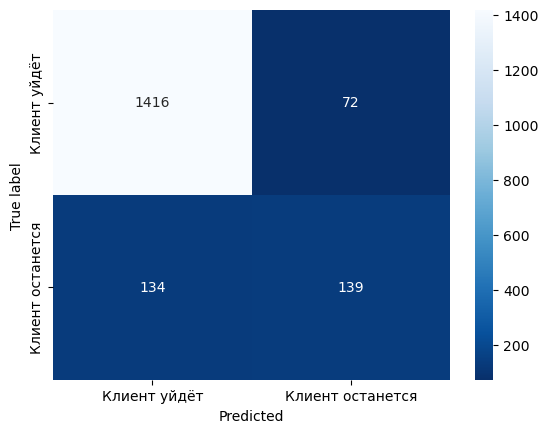

In [48]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r', xticklabels=[
            'Клиент уйдёт', 'Клиент останется'], yticklabels=['Клиент уйдёт', 'Клиент останется'])
plt.ylabel('True label')
plt.xlabel('Predicted'); 

Матрица ошибок показывает, модель обучилась довольно не плохо, учитывая что она верно предсказала 1416 клиентов которые расторгнут контракт и 139 клиентов которые останутся. Ошибки критичного рода - что клиент уйдет, но модель предсказала  что он останется всего 72. И 134 раза модель предсказала что клиент уйдет, но он останется. 

### Вывод:

Мы обучили 4 модели: `LogisticRegression` `RandomForestClassifier` `LGBMClasifier` `CatBoostClassifier`.
Лучшая модель оказалась **`CatBoostClassifier`**, на обучаеющей выборке модель набрала значение **AUC-ROC** - **0.8572**, а на тестовой выборке - **0.8818**. **Accuracy** модели на тестовой выборке состваляет **88.30%**.

Самыми важными признаками при обучении модели оказались : `duration_contract`, `total_charges`, `monthly_charges`.

Матрица ошибок показывает, что модель обучилась допольно не плохо, учитывая что она верно предсказала **1416** клиентов которые расторгнут контракт и **139** клиентов которые останутся. Ошибки критичного рода - что клиент уйдет, но модель предсказала  что он останется всего **72** и **134** раз модель неверно предсказала что клиент уйдет, хотя он останется. 

# Финальный вывод:

Оператор связи "Теледом" обратился к нам с проблемой: "клиенты расторгают договора и уходят к конкурентам". Чтобы предотвратить утечку клиентов сотрудники "ТелеДом" начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДом» поручил нам разработать модель которая будет предсказывать, разорвёт ли абонент договор.

Всю работу мы разделили на этапы: 
- **`Предобработка данных`** 
- **`Исследовательский анализ`** 
- **`Подготовка данных для обучения`** 
- **`Разработка моделей машинного обучения`**
- **`Выбор лучшей модели`** 

**Предобработка данных:**
- Названия колонок привели к стилю snake_case (в соответствии со стандартом PEP-8)
- Привели типы данных в соответствие
- Трансформировали бинарный признак senior_citizen.
- Создали дополнительные признаки status_contract (Статус контракта) и duration_contract (Прололжительность договора)
- Объединили данные в единый датасет.

**Исследовательский анализ данных:**
- Визуализировали данные
- Исследовали как таргет влияет на каждый признак
- Провели кореляционный анализ(построили тепловую карту)
- Подробно изучили категориальные и количественные признаки

**Подготовка данных для обучения:**
- Определили какие признаки будут мешать обучению модели и удалили их
- Провели разделение датасета на обучающую и тестовую выборки

**Разработка моделей машинного обучения:**
- К моделям машинного обучения применили PipeLine, перекрестную валидация с 5 фолдами и поиск по сетке гиперпараметров
- Обучили 4 модели: `LogisticRegression` `RandomForestClassifier` `LGBMClasifier` `CatBoostClassifier`. 
- Лучшая модель оказалась `CatBoostClassifier`, на обучаеющей выборке модель набрала значение `AUC-ROC` - **0.8572**, а на тестовой выборке - **0.8818**. `Accuracy` модели на тестовой выборке состваляет **88.30%**.


Данную модель можно брать в работу и использовать на текущих данных компании, для определения клиентов, которые могут расторгнуть договор. Для таких клиентов необходимо подготавливать специальные условия и скидки, чтобы удержать их. Также данную модель можно использовать в будущем уже для новых клиентов, чтобы избежать расторжения договора. 

Дополнительная рекомендация: 
Входе исследовательского анализа было выявлено, что большинство клиентов не пользуются дополнительными услугами компании. Можно провести маркетинговые мероприятия для информирования клиентов о дополнительных услугах. Либо можно разработать рекомендательную систему основанную на машинном обучении, для точечного предложения услуг.

Пользователи платящие в месяц более 80 у.е. часто расторгают контракт, рекомендуется разработать для таких клиентов отдельный тарифный план - XXL, с бОльшим набором услуг.

Также рекомендую разработать предложение для людей пожилого возраста, как показало исследование пенсионеров в разы меньше среди клиентов.